## PyPSA Beispiel 5

Sie haben die Aufgabe die Transformation der Stromversorgung für ein fiktives Land zu planen. Dabei sollen Sie in 10 Jahresschritten bis zum Jahr 2050 abschätzen, welche Erzeugungs- und Speicherkapazität benötigt wird. 
Im Jahr 2020 besteht der Erzeugungspark aus Kohle, Gas, Wind und PV. Die Kohle- und Gaskraftwerke sollen im Jahr 2030 und 2040 vom Netz gehen und durch PV, Wind, Batteriespeicher und H2-Kraftwerke ersetzt werden.



Hinweise:
* Zur Vereinfachung der Betrachtung geht es nur um den Stromsektor. 
* Sie können Annehmen, dass sich das Lastprofil nicht grundsätzlich ändert und für die Betrachtung hier in allen Zeiträumen gültig ist.
* Es soll keine Übertragung über Netze betrachtet werden. Betrachten Sie das System als einen Knoten für das gesamte Land
* Verwenden Sie eine Schleife um die zusätzlichen Komponenten hinzuzufügen, dies ist übersichtlicher

Systemskizze für ein Jahr:

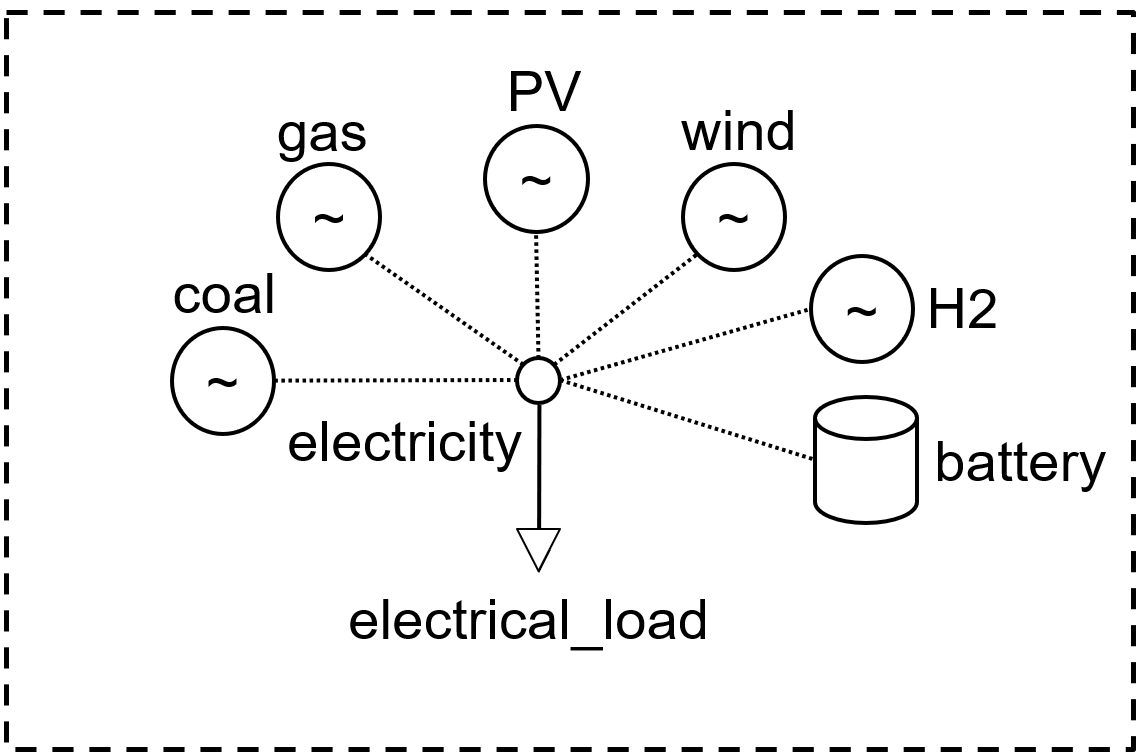

Importieren Sie die notwendigen Bibliotheken

In [1]:
import numpy as np
import pandas as pd
import pypsa
import matplotlib.pyplot as plt

Hier finden Sie zwei bereits definierte Funktionen die beim Umgang mit den Daten hilfreich sein können.

In [2]:
def rescale_1h_to_xh(data_1h, freq):
    data_xh = data_1h
    data_xh.index = pd.date_range('01/01/2019', periods=8760,freq='h')
    data_xh = data_xh.resample('{}h'.format(str(freq))).mean()
    return data_xh

def concat_data_n_times(data_1_year, n):
    df_data = pd.DataFrame()
    for i in range(data_1_year.shape[1]):
        data = []
        for k in range(n):
            data += list(data_1_year.iloc[:,i])
        df_data[str(data_1_year.columns[i])] = data
    return df_data

Lesen Sie zu nächst die Daten aus der Dateie 'data_PyPSA_05.csv' ein. Die Daten liegen in stündlicher Auflösung für 1 Jahr vor. Ändern Sie die Auflösung auf 3h. Verbinden Sie den Datensatz, so dass Sie insgesamt Datenpunkte für vier Einjahreszeiträume haben.

Die oben definierten Funktionen können dabei helfen.

In [3]:
df_data = pd.read_csv('data_PyPSA_05.csv')

In [4]:
freq = 3
years = [2020, 2030, 2040, 2050]

df_data = concat_data_n_times(rescale_1h_to_xh(df_data, freq), len(years))

Folgende Annahmen sollen im Modell berücksichtigt werden.

In [5]:
# Assumptions

# installed power https://energy-charts.info/charts/installed_power

p_nom_coal = 43740 # MW 
p_nom_gas = 35540 # MW 
p_nom_wind = 70000 # MW 
p_nom_pv = 54400 #MW 

# marginal cost
marginal_cost_coal = 28 # €/MWh_el  2017_Praxisbuch_Energiewirtschaft
marginal_cost_gas = 43.722 / 0.4 # €/MWh_el https://www.eex.com/de/marktdaten/erdgas/indizes
marginal_cost_h2 = 60 / 0.4 # €/MWh_el


co2_emissions_coal = 867 #kg/MWh for Hard coal https://www.volker-quaschning.de/datserv/CO2-spez/index_e.php
co2_emissions_gas = 358 #kg/MWh https://www.volker-quaschning.de/datserv/CO2-spez/index_e.php

build_year_fossil = 2010
lifetime_coal = 20
lifetime_gas = 30
lifetime_other = 20

# efficiency
efficiency_coal = 0.35
efficiency_gas = 0.55
efficiency_storage = 0.9 #roundtrip


# capital cost
capital_cost_pv = 87500 # €/MW as annuity
capital_cost_battery = 60000 #€/MWh as annuity
capital_cost_wind = 70000 # €/MWp as annuity
capital_cost_fuelcell = 115000 #€/MW as annuity

# maximum installable capacity in 10 years
p_nom_max_pv = 200000 # Annahme 
p_nom_max_fuelcell = 10000 # Annahme
p_nom_max_wind = 900000 # Annahme

Bauen Sie als Nächstes das Netzwerk auf. Einige Code Abschnitte sind bereits vorhanden. Für den Rest helfen die bereist definierten Abschnitte.

In [17]:
# Network and temporal definition 
network = pypsa.Network()

# Code from https://pypsa.readthedocs.io/en/latest/examples/multi-investment-optimisation.html
snapshots = pd.DatetimeIndex([])
for year in years:
    period = pd.date_range(
        start="{}-01-01 00:00".format(year),
        freq="{}h".format(str(freq)),
        periods=int(8760 / freq),
    )
    snapshots = snapshots.append(period)
    
network.snapshots = pd.MultiIndex.from_arrays([snapshots.year, snapshots])
network.investment_periods = years

# Code from https://pypsa.readthedocs.io/en/latest/examples/multi-investment-optimisation.html
network.investment_period_weightings["years"] = list(np.diff(years)) + [10]

r = 0.02
T = 0
for period, nyears in network.investment_period_weightings.years.items():
    discounts = [(1 / (1 + r) ** t) for t in range(T, T + nyears)]
    network.investment_period_weightings.at[period, "objective"] = sum(discounts)
    T += nyears
network.investment_period_weightings

network.snapshot_weightings[network.snapshot_weightings.columns] = float(freq)


#-----COMPONENTS-----
# carrier (optional)
network.add('Carrier', name = 'coal', co2_emissions = co2_emissions_coal)
network.add('Carrier', name = 'gas', co2_emissions = co2_emissions_gas)
network.add('Carrier', name = 'PV', co2_emissions = 0)
network.add('Carrier', name = 'Wind', co2_emissions = 0)
network.add('Carrier', name = 'H2', co2_emissions = 0)

# bus 
network.add('Bus', name = 'Electricity')

# Load
network.add('Load', name = 'Electrical Load', bus = 'Electricity', p_set = list(df_data['electrical load']))

# Add Existing PV, Wind, Coal and Gas Capacity Phase Out 
network.add('Generator', name = 'PV_2020', bus = 'Electricity', p_max_pu = list(df_data['PV']), p_nom = p_nom_pv, 
            carrier = 'PV', build_year = 2020, lifetime = lifetime_other)
network.add("Generator", name = "Wind_2020", bus = "Electricity", p_max_pu = list(df_data['wind']), p_nom = p_nom_wind, 
      lifetime = lifetime_other, build_year = 2020, carrier = "Wind")
network.add("Generator", name = "Coal", bus = "Electricity", p_nom = p_nom_coal, marginal_cost = marginal_cost_coal,
      lifetime = lifetime_coal, efficiency = efficiency_coal, build_year = build_year_fossil, carrier = "coal")
network.add("Generator", name = "Gas", bus = "Electricity", p_nom = p_nom_gas, marginal_cost = marginal_cost_gas, 
      lifetime = lifetime_gas, efficiency = efficiency_gas, build_year = build_year_fossil, carrier = "gas")

# add additional Components for 10 year Periods in a loop starting from 2030
for year in years:
    if year == 2020:
    # Überspringe das Jahr 2020        
        continue
    network.add("Generator", name = "PV_{}".format(year), bus = "Electricity", p_max_pu = list(df_data['PV']), 
                p_nom_max = p_nom_max_pv, capital_cost = capital_cost_pv, p_nom_extendable = True, 
                lifetime = lifetime_other, build_year = year, carrier = "PV")
    network.add("Generator", name = "Wind_{}".format(year), bus = "Electricity", p_max_pu = list(df_data['wind']), 
          p_nom_max = p_nom_max_wind, capital_cost = capital_cost_wind, p_nom_extendable = True, lifetime = lifetime_other, build_year = year, carrier = "Wind")
    network.add("Generator", name = "H2_{}".format(year), bus = "Electricity", p_nom_max = p_nom_max_fuelcell, 
          capital_cost = capital_cost_fuelcell, p_nom_extendable = True, lifetime = lifetime_other, 
          marginal_cost = marginal_cost_h2, build_year = year, carrier = "H2")
    network.add("StorageUnit", name = "Battery_{}".format(year), bus = "Electricity", capital_cost = capital_cost_battery, 
          build_year = year, p_nom_extendable = True, lifetime = lifetime_other, efficiency_store = efficiency_storage**0.5, 
          efficiency_dispatch = efficiency_storage**0.5 )



Überprüfen Sie mit n.generators, ob die gewünschten Generatoren hinzugefügt wurden.

In [18]:
network.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
PV_2020,Electricity,PQ,,54400.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Wind_2020,Electricity,PQ,,70000.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Coal,Electricity,PQ,,43740.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Gas,Electricity,PQ,,35540.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
PV_2030,Electricity,PQ,,0.0,0.0,True,0.0,200000.0,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Wind_2030,Electricity,PQ,,0.0,0.0,True,0.0,900000.0,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
H2_2030,Electricity,PQ,,0.0,0.0,True,0.0,10000.0,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
PV_2040,Electricity,PQ,,0.0,0.0,True,0.0,200000.0,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Wind_2040,Electricity,PQ,,0.0,0.0,True,0.0,900000.0,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


Optimieren Sie Netzwerk mit: 

network.optimize(solver_name = 'gurobi', multi_investment_periods=True, threads = 1)

In [19]:
network.optimize(solver_name = 'gurobi', multi_investment_periods=True, threads = 1)

Index(['Electricity'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - threads: 1
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 24.62it/s]
INFO:linopy.io: Writing time: 1.5s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-hotn9tpp.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-hotn9tpp.lp


Reading time = 0.50 seconds


INFO:gurobipy:Reading time = 0.50 seconds


obj: 242381 rows, 108052 columns, 449371 nonzeros


INFO:gurobipy:obj: 242381 rows, 108052 columns, 449371 nonzeros


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


Threads  1


INFO:gurobipy:Threads  1


INFO:gurobipy:


Optimize a model with 242381 rows, 108052 columns and 449371 nonzeros


INFO:gurobipy:Optimize a model with 242381 rows, 108052 columns and 449371 nonzeros


Model fingerprint: 0xf98ff1c2


INFO:gurobipy:Model fingerprint: 0xf98ff1c2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-04, 3e+00]


INFO:gurobipy:  Matrix range     [3e-04, 3e+00]


  Objective range  [8e+02, 2e+06]


INFO:gurobipy:  Objective range  [8e+02, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+01, 9e+05]


INFO:gurobipy:  RHS range        [2e+01, 9e+05]


Presolve removed 136802 rows and 18331 columns


INFO:gurobipy:Presolve removed 136802 rows and 18331 columns


Presolve time: 0.65s


INFO:gurobipy:Presolve time: 0.65s


Presolved: 105579 rows, 89721 columns, 296369 nonzeros


INFO:gurobipy:Presolved: 105579 rows, 89721 columns, 296369 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    9.0860921e+10   6.328188e+07   0.000000e+00      1s


INFO:gurobipy:       0    9.0860921e+10   6.328188e+07   0.000000e+00      1s


   50364    1.7844382e+12   4.528891e+08   0.000000e+00      5s


INFO:gurobipy:   50364    1.7844382e+12   4.528891e+08   0.000000e+00      5s


   69000    2.0724681e+12   0.000000e+00   0.000000e+00      9s


INFO:gurobipy:   69000    2.0724681e+12   0.000000e+00   0.000000e+00      9s


INFO:gurobipy:


Solved in 69000 iterations and 9.20 seconds (6.30 work units)


INFO:gurobipy:Solved in 69000 iterations and 9.20 seconds (6.30 work units)


Optimal objective  2.072468060e+12


INFO:gurobipy:Optimal objective  2.072468060e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 108052 primals, 242381 duals
Objective: 2.07e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

Lassen Sie sich die Generatorleistungen als Plot ausgeben. Verwenden die das Attribut alpha des Plot Befehls im die Graphen transparenter zu machen.

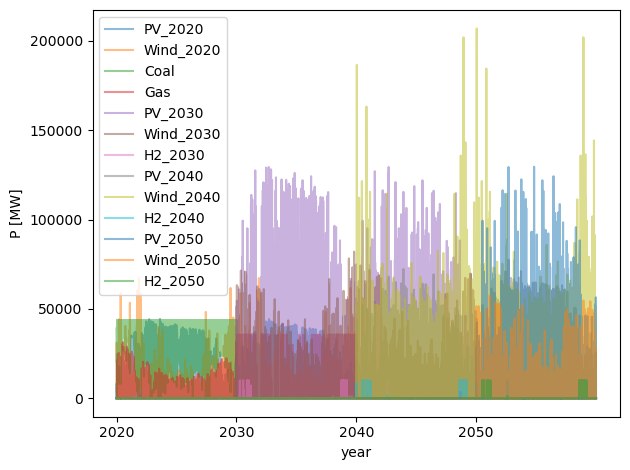

In [20]:
ax = network.generators_t.p.plot(alpha = 0.5)

# Nur die Jahre (Periods) als x-Tick-Labels anzeigen
ax.set_xticks(range(0,len(network.generators_t.p),2920))  # Setze Positionen
ax.set_xticklabels(years)
ax.set_xlabel('year')
ax.set_ylabel('P [MW]')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

Der folgende Code zeigt die erzeugte Energie über den Investitionszeitraum.

<Axes: xlabel='Investment Period', ylabel='Generation'>

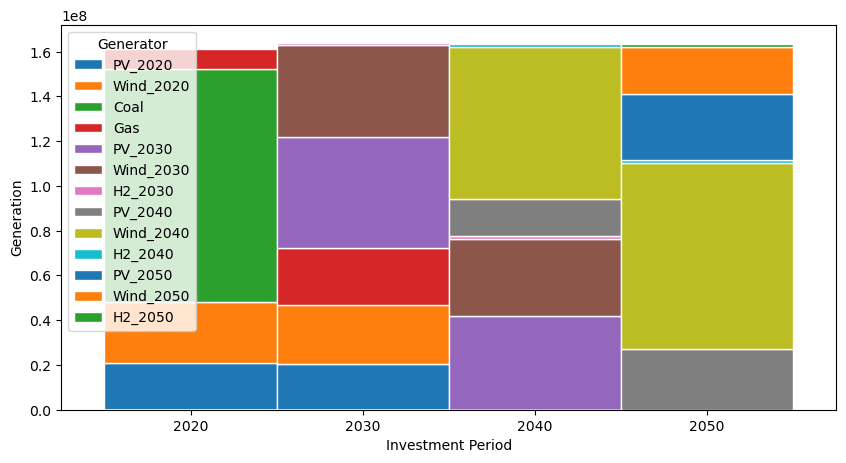

In [21]:
#Code from https://pypsa.readthedocs.io/en/latest/examples/multi-investment-optimisation.html
df = network.generators_t.p.groupby(level=0).sum()
df.plot.bar(
    stacked=True,
    edgecolor="white",
    width=1,
    ylabel="Generation",
    xlabel="Investment Period",
    rot=0,
    figsize=(10, 5),
)

Der folgende Code zeigt die installierten Leistungen, über den Investitionszeitraum.

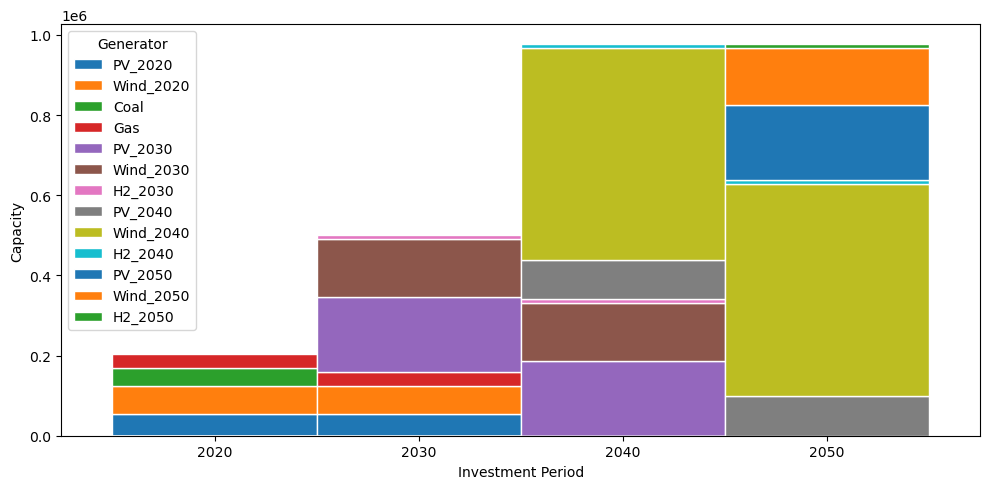

In [22]:
# Code from https://pypsa.readthedocs.io/en/latest/examples/multi-investment-optimisation.html

c = "Generator"
df = pd.concat(
    {
        period: network.get_active_assets(c, period) * network.df(c).p_nom_opt
        for period in network.investment_periods
    },
    axis=1,
)
df.T.plot.bar(
    stacked=True,
    edgecolor="white",
    width=1,
    ylabel="Capacity",
    xlabel="Investment Period",
    rot=0,
    figsize=(10, 5),
)
plt.tight_layout()